In [1]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.3 MB/s eta 0:00:0000:01


In [2]:
# imports_utils.py
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from concurrent.futures import ThreadPoolExecutor

def print_time(start, message):
    end = time.time()
    elapsed = end - start
    print(f"{message}: {elapsed:.2f} seconds")
    return elapsed

Data loading and splitting (None samples): 1.53 seconds


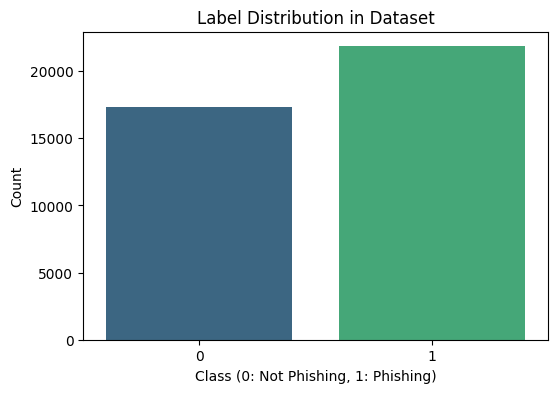

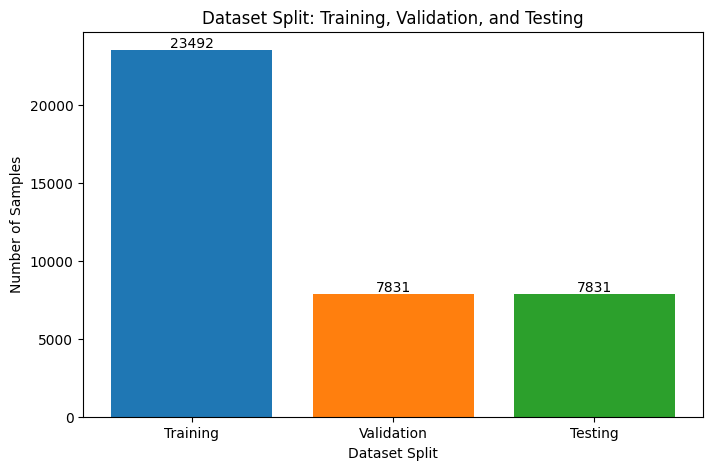

In [3]:
# data_processing.py
#from imports_utils import *

def load_and_split_data(file_path, num_samples=None):
    start = time.time()
    df = pd.read_csv(file_path)
    df = df[['body', 'label']].dropna().head(num_samples)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['body'], df['label'], test_size=0.2, random_state=42
    )
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        train_texts, train_labels, test_size=0.25, random_state=42
    )
    data_time = print_time(start, f"Data loading and splitting ({num_samples} samples)")
    return df, train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, data_time

def plot_data_visualizations(df, train_texts, val_texts, test_texts):
    # Label Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='label', data=df, palette='viridis')
    plt.title('Label Distribution in Dataset')
    plt.xlabel('Class (0: Not Phishing, 1: Phishing)')
    plt.ylabel('Count')
    plt.show()

    # Dataset Split
    plt.figure(figsize=(8, 5))
    split_counts = [len(train_texts), len(val_texts), len(test_texts)]
    split_labels = ['Training', 'Validation', 'Testing']
    plt.bar(split_labels, split_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.xlabel('Dataset Split')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Split: Training, Validation, and Testing')
    for i, v in enumerate(split_counts):
        plt.text(i, v + 1, str(v), ha='center', va='bottom')
    plt.show()

if __name__ == "__main__":
    df, train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, data_time = load_and_split_data(
        "/kaggle/input/phishing-email-dataset/CEAS_08.csv"
    )
    plot_data_visualizations(df, train_texts, val_texts, test_texts)

In [4]:
# model_setup.py
#from imports_utils import *

def initialize_model(model_name="distilbert-base-uncased"):
    start = time.time()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model_time = print_time(start, "Model loading and device transfer")
    return tokenizer, model, device, model_time

if __name__ == "__main__":
    tokenizer, model, device, model_time = initialize_model()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model loading and device transfer: 16.53 seconds


Model loading and device transfer: 0.39 seconds
Data loading and splitting (None samples): 0.80 seconds
Text to graph conversion: 57.29 seconds


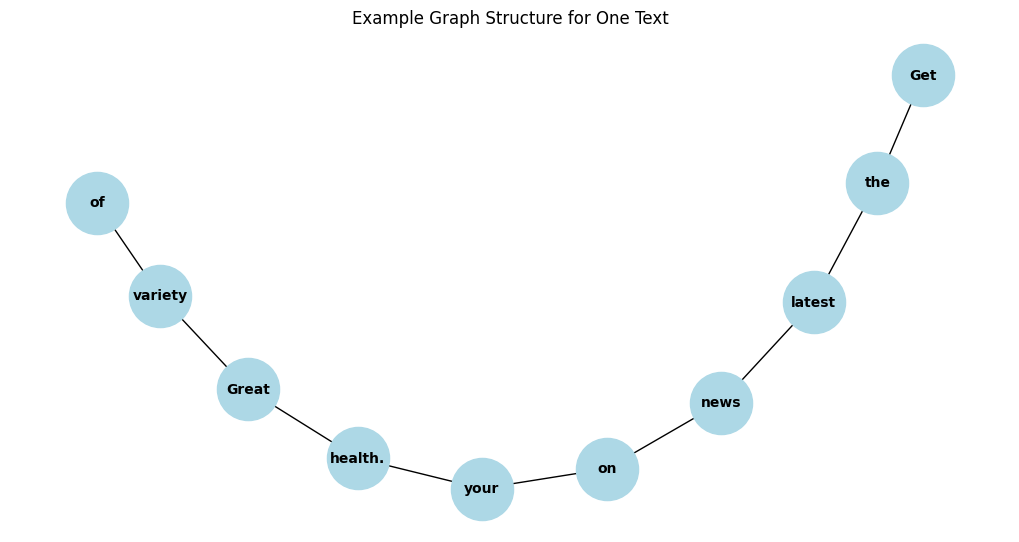

In [5]:
# graph_conversion.py
#from imports_utils import *

class TextDataset(Dataset):
    def __init__(self, texts, max_words=10):
        self.texts = texts.values if isinstance(texts, pd.Series) else texts
        self.max_words = max_words

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

def extract_features_batched(texts, tokenizer, model, device, batch_size=32):
    dataloader = DataLoader(TextDataset(texts), batch_size=batch_size, shuffle=False)
    all_features = []
    for batch_texts in dataloader:
        inputs = tokenizer(
            list(batch_texts), padding="max_length", truncation=True, max_length=128, return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        features = outputs.last_hidden_state.mean(dim=1)
        all_features.append(features.cpu())  # Move to CPU to save GPU memory
    return torch.cat(all_features, dim=0)

def text_to_graph(texts, tokenizer, model, device, batch_size=32):
    start = time.time()
    features = extract_features_batched(texts, tokenizer, model, device, batch_size)
    all_graphs = []
    feature_idx = 0
    
    for text in texts:
        words = text.split()[:10]
        num_words = len(words)
        if num_words < 2:
            all_graphs.append(None)
            continue
        edge_index = torch.tensor([[j, j+1] for j in range(num_words-1)], dtype=torch.long).t().contiguous()
        word_features = features[feature_idx].repeat(num_words, 1)  # Reuse text-level features
        all_graphs.append(Data(x=word_features, edge_index=edge_index))
        feature_idx += 1
    
    graph_time = print_time(start, "Text to graph conversion")
    return [g for g in all_graphs if g is not None], graph_time

def plot_example_graph(graph, text):
    G = nx.Graph()
    words = text.split()[:10]
    for i, word in enumerate(words):
        G.add_node(i, label=word)
    edges = graph.edge_index.t().cpu().numpy()
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    plt.figure(figsize=(10, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_color='lightblue', 
            node_size=2000, font_size=10, font_weight='bold')
    plt.title("Example Graph Structure for One Text")
    plt.show()

if __name__ == "__main__":
    tokenizer, model, device, _ = initialize_model()
    _, train_texts, _, _, _, _, _, _ = load_and_split_data("/kaggle/input/phishing-email-dataset/CEAS_08.csv")
    train_graphs, graph_time = text_to_graph(train_texts, tokenizer, model, device)
    if train_graphs:
        plot_example_graph(train_graphs[0], train_texts.iloc[0])

In [6]:
class PhishingGNN(torch.nn.Module):
    def __init__(self, in_channels=768, hidden_channels=256, out_channels=2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x.mean(dim=0), dim=-1)

In [16]:
def train_gnn(train_graphs, val_graphs, train_labels, val_labels, device, epochs=7):
    gnn_model = PhishingGNN().to(device)
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.0001)
    
    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    start = time.time()
    for epoch in range(epochs):
        gnn_model.train()
        total_train_loss, total_train_correct = 0, 0
        
        # Training loop
        epoch_start = time.time()
        for i, graph in enumerate(train_graphs):
            graph = graph.to(device)
            label = torch.tensor([train_labels.iloc[i]], dtype=torch.long, device=device)
            optimizer.zero_grad()
            out = gnn_model(graph)
            loss = F.nll_loss(out.unsqueeze(0), label)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            pred = out.argmax(dim=-1).item()
            total_train_correct += int(pred == label.item())
        
        # Calculate training loss and accuracy
        avg_train_loss = total_train_loss / len(train_graphs)
        train_accuracy = total_train_correct / len(train_graphs)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        gnn_model.eval()
        total_val_loss, total_val_correct = 0, 0
        with torch.no_grad():
            for i, graph in enumerate(val_graphs):
                graph = graph.to(device)
                label = torch.tensor([val_labels.iloc[i]], dtype=torch.long, device=device)
                out = gnn_model(graph)
                loss = F.nll_loss(out.unsqueeze(0), label)
                total_val_loss += loss.item()
                pred = out.argmax(dim=-1).item()
                total_val_correct += int(pred == label.item())
        
        # Calculate validation loss and accuracy
        avg_val_loss = total_val_loss / len(val_graphs)
        val_accuracy = total_val_correct / len(val_graphs)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        print_time(epoch_start, f"Training time for epoch {epoch+1}")
    
    train_time = print_time(start, "Total training time")
    return gnn_model, train_losses, val_losses, train_accuracies, val_accuracies, train_time

In [17]:
def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs=7):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot Loss Curves
    ax1.plot(range(1, epochs + 1), train_losses, marker='o', color='b', label='Train Loss')
    ax1.plot(range(1, epochs + 1), val_losses, marker='o', color='r', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.grid(True)
    ax1.legend()
    
    # Plot Accuracy Curves
    ax2.plot(range(1, epochs + 1), train_accuracies, marker='o', color='b', label='Train Accuracy')
    ax2.plot(range(1, epochs + 1), val_accuracies, marker='o', color='r', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [15]:
# evaluation_results.py
#from imports_utils import *

def evaluate_model(gnn_model, test_graphs, test_labels, device):
    
    start = time.time()
    gnn_model.eval()
    predictions, true_labels, probs = [], [], []
    with torch.no_grad():
        for i, graph in enumerate(test_graphs):
            graph = graph.to(device)
            out = gnn_model(graph)
            pred = out.argmax(dim=-1).item()
            prob = torch.exp(out)[1].item()  # Probability of the positive class
            predictions.append(pred)
            true_labels.append(test_labels.iloc[i])
            probs.append(prob)
    eval_time = print_time(start, "Evaluation time")
    return predictions, true_labels, probs, eval_time


def plot_results(true_labels, predictions, probs, times, train_losses, val_losses, train_accuracies, val_accuracies):
   
    start = time.time()

    # Test Accuracy and Classification Report
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(true_labels, predictions))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], 
                yticklabels=['Not Phishing', 'Phishing'])
    plt.xlabel('Predictions')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(true_labels, probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Execution Time Breakdown
    stages = ['Data Loading', 'Model Loading', 'Graph Conversion', 'Training', 'Evaluation']
    plt.figure(figsize=(10, 5))
    plt.bar(stages, times, color='skyblue')
    plt.xlabel('Stage')
    plt.ylabel('Time (seconds)')
    plt.title('Execution Time Breakdown')
    plt.xticks(rotation=45)
    plt.show()

    # Training and Validation Loss Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Training and Validation Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    result_time = print_time(start, "Result calculation and plotting")
    return result_time


if __name__ == "__main__":
    total_start = time.time()

    # Load and split data
    df, train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, data_time = load_and_split_data(
        "/kaggle/input/phishing-email-dataset/CEAS_08.csv"
    )

    # Initialize the tokenizer, model, and device
    tokenizer, model, device, model_time = initialize_model()

    # Convert text data into graphs
    train_graphs, graph_time_train = text_to_graph(train_texts, tokenizer, model, device)
    val_graphs, graph_time_val = text_to_graph(val_texts, tokenizer, model, device)
    test_graphs, graph_time_test = text_to_graph(test_texts, tokenizer, model, device)

   

Data loading and splitting (None samples): 0.77 seconds
Model loading and device transfer: 0.41 seconds
Text to graph conversion: 55.71 seconds
Text to graph conversion: 18.65 seconds
Text to graph conversion: 19.28 seconds


Epoch 1/7, Train Loss: 0.0608, Val Loss: 0.0345, Train Acc: 0.9802, Val Acc: 0.9890
Training time for epoch 1: 117.13 seconds
Epoch 2/7, Train Loss: 0.0308, Val Loss: 0.0273, Train Acc: 0.9901, Val Acc: 0.9921
Training time for epoch 2: 114.85 seconds
Epoch 3/7, Train Loss: 0.0225, Val Loss: 0.0230, Train Acc: 0.9928, Val Acc: 0.9937
Training time for epoch 3: 114.57 seconds
Epoch 4/7, Train Loss: 0.0171, Val Loss: 0.0213, Train Acc: 0.9949, Val Acc: 0.9946
Training time for epoch 4: 114.75 seconds
Epoch 5/7, Train Loss: 0.0137, Val Loss: 0.0210, Train Acc: 0.9963, Val Acc: 0.9950
Training time for epoch 5: 114.66 seconds
Epoch 6/7, Train Loss: 0.0112, Val Loss: 0.0221, Train Acc: 0.9971, Val Acc: 0.9953
Training time for epoch 6: 114.55 seconds
Epoch 7/7, Train Loss: 0.0095, Val Loss: 0.0227, Train Acc: 0.9975, Val Acc: 0.9945
Training time for epoch 7: 114.61 seconds
Total training time: 805.12 seconds
Evaluation time: 15.32 seconds
Test Accuracy: 0.9951
Classification Report:
      

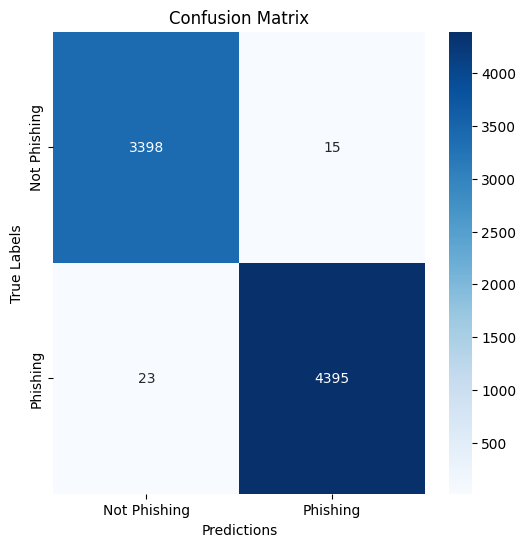

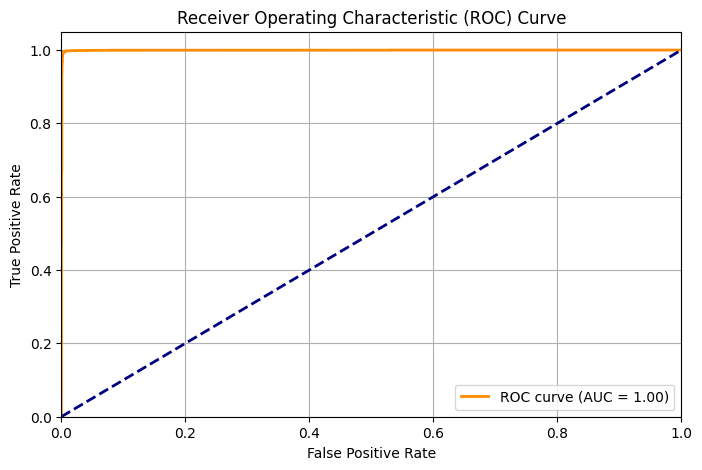

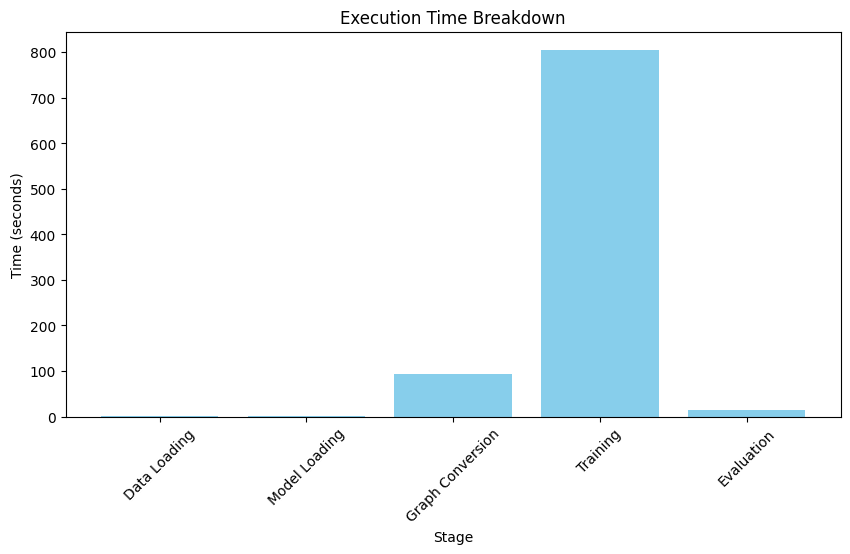

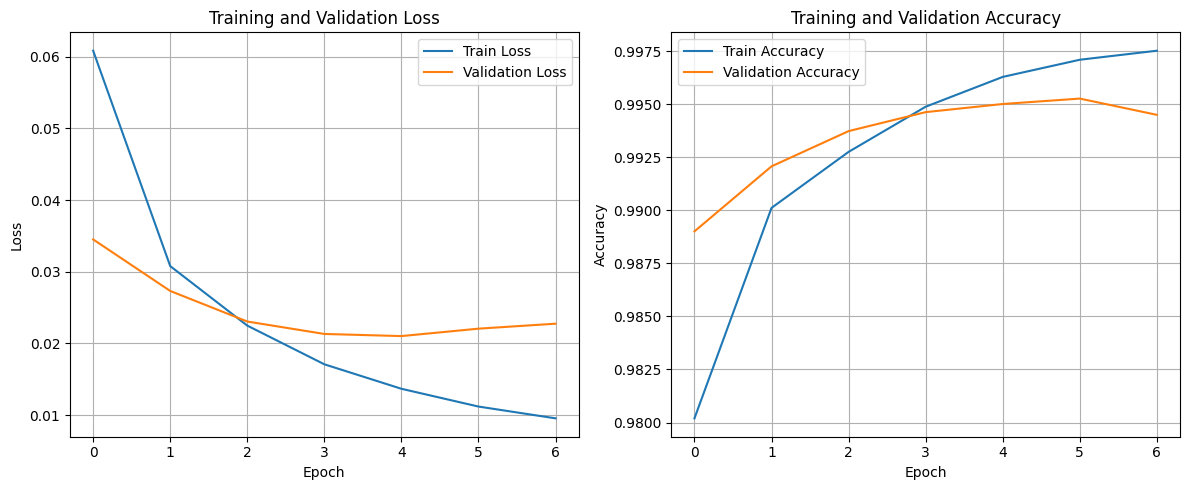

Result calculation and plotting: 1.04 seconds
Total execution time: 937.24 seconds


937.2360570430756

In [18]:
 # Train the GNN model
gnn_model, train_losses, val_losses, train_accuracies, val_accuracies, train_time = train_gnn(
        train_graphs, val_graphs, train_labels, val_labels, device
    )

    # Evaluate the model on the test set
predictions, true_labels, probs, eval_time = evaluate_model(gnn_model, test_graphs, test_labels, device)

    # Execution times for different stages
times = [data_time, model_time, graph_time_train + graph_time_val + graph_time_test, train_time, eval_time]

    # Plot results
result_time = plot_results(
        true_labels, predictions, probs, times, train_losses, val_losses, train_accuracies, val_accuracies
    )

    # Print total execution time
print_time(total_start, "Total execution time")